In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, TimeDistributed, BatchNormalization, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from kerastuner import RandomSearch
import keras_tuner as kt
import keras

<ipython-input-3-d9ed943fd811>:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ravdess_folder_path = '/content/drive/MyDrive/IE Project/audio_speech_actors_01-24'

In [ ]:
def load_data_ravdess_raw_audio(directory):
    X = []
    y = []
    max_audio_length = 0
    
    for actor_dir in os.listdir(directory):
        actor_path = os.path.join(directory, actor_dir)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(actor_path, file)
                    emotion = int(file.split("-")[2])
                    y.append(emotion)
                    
                    audio, sr = librosa.load(file_path, sr=None) # Loaded with original sampling rate
                    
                    max_audio_length = max(max_audio_length, len(audio))
                    
                    X.append(audio)
    
    X = [np.pad(x, (0, max_audio_length - len(x)), 'constant') if len(x) < max_audio_length else x[:max_audio_length] for x in X]
                    
    return np.array(X), np.array(y)

Raw audio data consists of a continuous sequence of digital samples that represent the amplitude of an audio signal at specific points in time. These samples are taken at a fixed rate called the sampling rate, which determines the number of samples taken per second. The sampling rate is typically measured in Hertz (Hz), and higher sampling rates result in a more accurate representation of the original analog audio signal.

For example, a common sampling rate for digital audio is 44,100 Hz, which means that 44,100 samples are taken per second. Each sample is a numerical value that represents the amplitude of the audio waveform at a specific point in time.

In [ ]:
# X, y = load_data_ravdess_raw_audio(ravdess_folder_path)

In [ ]:
# np.save('/content/drive/MyDrive/IE Project/MLP (Ali)/X & y/X.npy', X)
# np.save('/content/drive/MyDrive/IE Project/MLP (Ali)/X & y/y.npy', y)

In [ ]:
X = np.load('/content/drive/MyDrive/IE Project/MLP (Ali)/X & y/X.npy')
y = np.load('/content/drive/MyDrive/IE Project/MLP (Ali)/X & y/y.npy')

Normalizing the input data and one-hot encoding the targets

In [ ]:
X.shape

(1440, 253053)

In [ ]:
X[0:5]

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.1552734e-05, 1.2207031e-04, 9.1552734e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()

In [ ]:
X.shape

(1440, 253053)

In [ ]:
X[0:5]

array([[0.40976462, 0.32462686, 0.29932886, ..., 0.        , 0.        ,
        0.        ],
       [0.41238013, 0.32761192, 0.30134228, ..., 0.        , 0.        ,
        0.        ],
       [0.40976462, 0.32462686, 0.29932886, ..., 0.        , 0.        ,
        0.        ],
       [0.40976462, 0.32462686, 0.29932886, ..., 0.        , 0.        ,
        0.        ],
       [0.40976462, 0.32462686, 0.29932886, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

Using raw audio data directly in an LSTM model poses issues due to the high dimensionality and temporal structure of the audio signal. The large number of time steps can cause vanishing gradients, hindering long-term dependency learning. Additionally, raw audio signals have complex structures that are better captured using more informative representations like MFCC, Chroma, or Mel spectrograms. By using these features, we can improve the model's generalization and reduce the risk of overfitting caused by limited training data.

# Feature Extraction

In [ ]:
def extract_features_from_array(X, sr=44100):
    feature_list = []

    for audio_data in X:
        # Reshape audio data to 1D
        audio_data = audio_data.reshape(-1)

        # MFCCs
        mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)

        # Chroma features
        chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)

        # Spectral contrast
        spec_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)

        # Tonnetz
        tonnetz = librosa.feature.tonnetz(y=audio_data, sr=sr)

        # Pitch (F0)
        pitches, _ = librosa.core.piptrack(y=audio_data, sr=sr)
        pitch = np.max(pitches, axis=0)

        # RMS energy
        rms = librosa.feature.rms(y=audio_data)

        # Stack all features
        features = np.vstack([mfcc, chroma_stft, spec_contrast, tonnetz, pitch, rms])

        feature_list.append(features)

    return np.array(feature_list)

In [ ]:
X_features = extract_features_from_array(X)

In [ ]:
X_features.shape

(1440, 13, 495)

In [ ]:
folder_path = '/content/drive/MyDrive/IE Project/MLP (Ali)/X & y'
file_name = 'X_features.npy'

In [ ]:
#np.save(f'{folder_path}/{file_name}', X_features)

In [ ]:
X_features = np.load(f'{folder_path}/{file_name}')

# LSTM Model

In [ ]:
X_features.shape

(1440, 40, 495)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
# Calculate the input shape (number of features)
input_shape = X_train.shape[1], X_train.shape[2]

In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(input_shape)),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100
27/27 [==============================] - 9s 39ms/step - loss: 2.0832 - accuracy: 0.1377 - val_loss: 2.0772 - val_accuracy: 0.1458
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 2.0710 - accuracy: 0.1377 - val_loss: 2.0784 - val_accuracy: 0.1458
Epoch 3/100
27/27 [==============================] - 0s 8ms/step - loss: 2.0637 - accuracy: 0.1366 - val_loss: 2.0733 - val_accuracy: 0.1076
Epoch 4/100
27/27 [==============================] - 0s 9ms/step - loss: 2.0563 - accuracy: 0.1400 - val_loss: 2.0685 - val_accuracy: 0.1181
Epoch 5/100
27/27 [==============================] - 0s 9ms/step - loss: 2.0270 - accuracy: 0.1840 - val_loss: 2.0719 - val_accuracy: 0.1319
Epoch 6/100
27/27 [==============================] - 0s 9ms/step - loss: 1.9891 - accuracy: 0.2049 - val_loss: 1.9889 - val_accuracy: 0.2188
Epoch 7/100
27/27 [==============================] - 0s 8ms/step - loss: 1.9569 - accuracy: 0.2025 - val_loss: 2.0000 - val_accuracy: 0.1528
Epoch 8/100


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

9/9 [==============================] - 0s 4ms/step - loss: 2.0976 - accuracy: 0.2743
Test accuracy: 0.2743055522441864


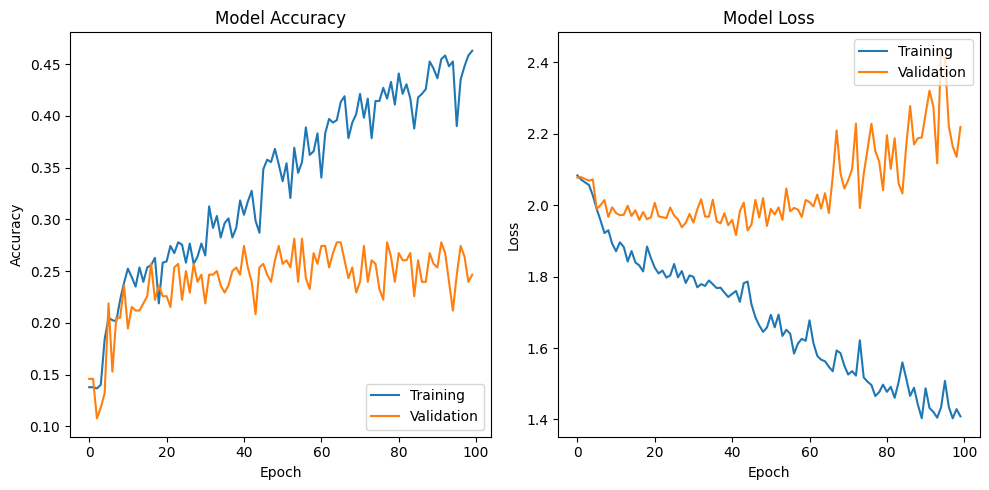

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# More Complex LSTM model

In [ ]:
model = Sequential()

# Add multiple LSTM layers with dropout and recurrent dropout
model.add(LSTM(128, input_shape=(input_shape), return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())

# Add Dense layers with dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 128)           319488    
                                                                 
 batch_normalization (BatchN  (None, 40, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_3 (LSTM)               (None, 40, 128)           131584    
                                                                 
 batch_normalization_1 (Batc  (None, 40, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 batch_normalization_2 (Batc  (None, 128)             

In [ ]:
# Set the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/100
27/27 [==============================] - 13s 217ms/step - loss: 2.4932 - accuracy: 0.1389 - val_loss: 2.0749 - val_accuracy: 0.1493
Epoch 2/100
27/27 [==============================] - 5s 190ms/step - loss: 2.3125 - accuracy: 0.1343 - val_loss: 2.0796 - val_accuracy: 0.1111
Epoch 3/100
27/27 [==============================] - 5s 194ms/step - loss: 2.2617 - accuracy: 0.1262 - val_loss: 2.0782 - val_accuracy: 0.1111
Epoch 4/100
27/27 [==============================] - 5s 191ms/step - loss: 2.1931 - accuracy: 0.1192 - val_loss: 2.0779 - val_accuracy: 0.1354
Epoch 5/100
27/27 [==============================] - 5s 201ms/step - loss: 2.1284 - accuracy: 0.1366 - val_loss: 2.0776 - val_accuracy: 0.1458
Epoch 6/100
27/27 [==============================] - 5s 192ms/step - loss: 2.1520 - accuracy: 0.1053 - val_loss: 2.0753 - val_accuracy: 0.1458
Epoch 7/100
27/27 [==============================] - 5s 193ms/step - loss: 2.1273 - accuracy: 0.1435 - val_loss: 2.0760 - val_accuracy: 0.125

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

9/9 [==============================] - 0s 38ms/step - loss: 2.1615 - accuracy: 0.1632
Test accuracy: 0.1631944477558136


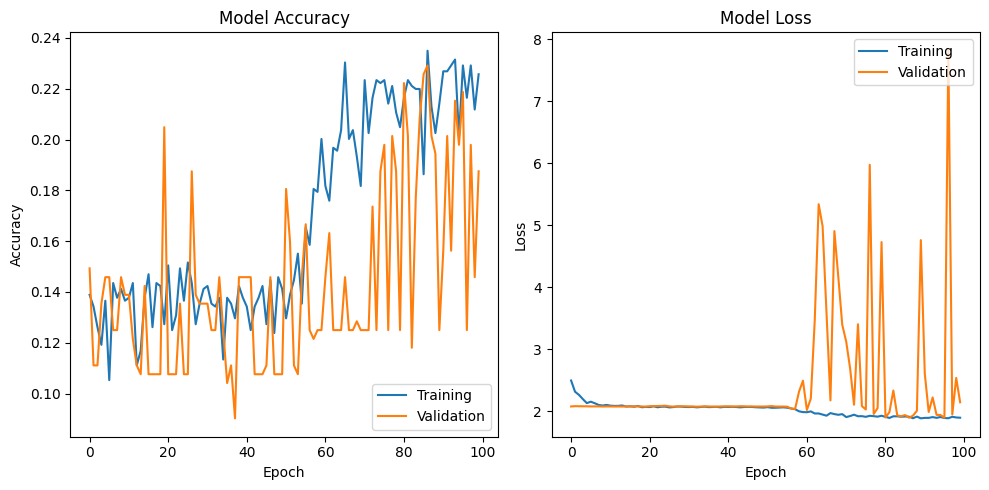

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Hyperparameter Tuning LSTM

In [ ]:
def build_model(hp):
    model = Sequential([
        LSTM(hp.Int("lstm_1_units", min_value=64, max_value=256, step=32), return_sequences=True, input_shape=input_shape),
        LSTM(hp.Int("lstm_2_units", min_value=32, max_value=128, step=32)),
        Dense(hp.Int("dense_1_units", min_value=16, max_value=64, step=16), activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,  
    executions_per_trial=3,
    directory='my_dir',
    project_name='lstm_hyperparam_tuning'
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 50 Complete [00h 00m 21s]
val_accuracy: 0.12615741044282913

Best val_accuracy So Far: 0.35879629850387573
Total elapsed time: 00h 24m 49s


In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters)

Best hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f070b503f70>


In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

for hp in best_hp.space:
    hp_name = hp.name
    hp_value = best_hp.get(hp_name)
    print(f"{hp_name}: {hp_value}")

lstm_1_units: 256
lstm_2_units: 128
dense_1_units: 48
learning_rate: 0.0001


# Using the best parameters

In [ ]:
def build_model():
    model = Sequential([
        LSTM(256, return_sequences=True, input_shape=input_shape),
        LSTM(128),
        Dense(48, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = build_model()

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=2
)

Epoch 1/100
27/27 - 4s - loss: 2.0772 - accuracy: 0.1308 - val_loss: 2.0707 - val_accuracy: 0.1389 - 4s/epoch - 161ms/step
Epoch 2/100
27/27 - 0s - loss: 2.0406 - accuracy: 0.1644 - val_loss: 2.0439 - val_accuracy: 0.1597 - 254ms/epoch - 9ms/step
Epoch 3/100
27/27 - 0s - loss: 2.0067 - accuracy: 0.1736 - val_loss: 1.9876 - val_accuracy: 0.1667 - 222ms/epoch - 8ms/step
Epoch 4/100
27/27 - 0s - loss: 1.9157 - accuracy: 0.2130 - val_loss: 1.9372 - val_accuracy: 0.2465 - 226ms/epoch - 8ms/step
Epoch 5/100
27/27 - 0s - loss: 1.8549 - accuracy: 0.2558 - val_loss: 1.9023 - val_accuracy: 0.2569 - 221ms/epoch - 8ms/step
Epoch 6/100
27/27 - 0s - loss: 1.8358 - accuracy: 0.2477 - val_loss: 1.8734 - val_accuracy: 0.2535 - 220ms/epoch - 8ms/step
Epoch 7/100
27/27 - 0s - loss: 1.7941 - accuracy: 0.3009 - val_loss: 1.8794 - val_accuracy: 0.2847 - 218ms/epoch - 8ms/step
Epoch 8/100
27/27 - 0s - loss: 1.8289 - accuracy: 0.2674 - val_loss: 1.8684 - val_accuracy: 0.2708 - 221ms/epoch - 8ms/step
Epoch 9/1

9/9 [==============================] - 0s 4ms/step - loss: 2.2945 - accuracy: 0.3333
Test accuracy: 0.3333333432674408


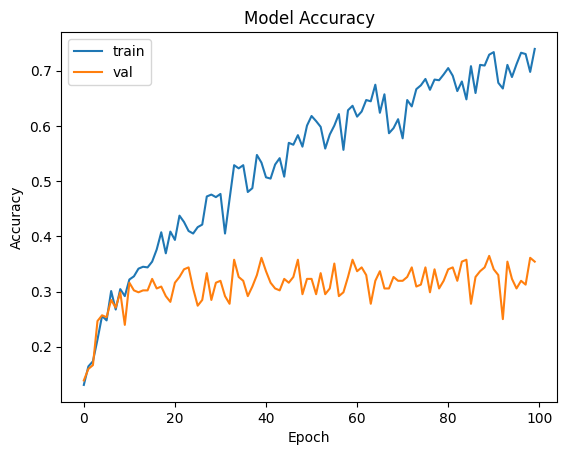

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# CNN Model

In [ ]:
def extract_features(X, sr=22050, n_mfcc=13):
    features_list = []

    for audio_data in X:
        # Ensure the audio data is 1D
        audio_data = audio_data.reshape(-1)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc)

        # Extract chroma features
        chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)

        # Extract spectral contrast features
        spec_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)

        # Stack all features
        features = np.vstack([mfcc, chroma_stft, spec_contrast])

        features_list.append(features)

    return np.array(features_list)

In [ ]:
extracted_features = extract_features(X)

In [ ]:
extracted_features.shape

(1440, 32, 495)

In [ ]:
y.shape

(1440, 8)

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
extracted_features = scaler.fit_transform(extracted_features.reshape(extracted_features.shape[0], -1)).reshape(extracted_features.shape)

# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
X_train.shape

(864, 32, 495)

In [ ]:
# shapes of the arrays
train_shape = X_train.shape
val_shape = X_val.shape
test_shape = X_test.shape

# reshape
X_train_reshaped = X_train.reshape(train_shape[0], train_shape[1], train_shape[2], 1)
X_val_reshaped = X_val.reshape(val_shape[0], val_shape[1], val_shape[2], 1)
X_test_reshaped = X_test.reshape(test_shape[0], test_shape[1], test_shape[2], 1)

In [ ]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(train_shape[1], train_shape[2], 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
27/27 [==============================] - 15s 38ms/step - loss: 2.0857 - accuracy: 0.1319 - val_loss: 2.0594 - val_accuracy: 0.1424
Epoch 2/30
27/27 [==============================] - 1s 30ms/step - loss: 1.9945 - accuracy: 0.1794 - val_loss: 2.0005 - val_accuracy: 0.1632
Epoch 3/30
27/27 [==============================] - 1s 30ms/step - loss: 1.9484 - accuracy: 0.2106 - val_loss: 1.9418 - val_accuracy: 0.2431
Epoch 4/30
27/27 [==============================] - 1s 30ms/step - loss: 1.8524 - accuracy: 0.2755 - val_loss: 1.9049 - val_accuracy: 0.2257
Epoch 5/30
27/27 [==============================] - 1s 30ms/step - loss: 1.7371 - accuracy: 0.3275 - val_loss: 1.8003 - val_accuracy: 0.2951
Epoch 6/30
27/27 [==============================] - 1s 30ms/step - loss: 1.6150 - accuracy: 0.3831 - val_loss: 1.6942 - val_accuracy: 0.3472
Epoch 7/30
27/27 [==============================] - 1s 30ms/step - loss: 1.4698 - accuracy: 0.4630 - val_loss: 1.7528 - val_accuracy: 0.3368
Epoch 8/30
2

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

9/9 [==============================] - 0s 12ms/step - loss: 4.7645 - accuracy: 0.4549
Test accuracy: 0.4548611044883728


In [ ]:
model1D = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model1D.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model1D.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), verbose=1)


Epoch 1/100
27/27 [==============================] - 3s 14ms/step - loss: 2.1130 - accuracy: 0.1319 - val_loss: 2.0733 - val_accuracy: 0.1458
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 2.0660 - accuracy: 0.1493 - val_loss: 2.0780 - val_accuracy: 0.1493
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 2.0636 - accuracy: 0.1481 - val_loss: 2.0743 - val_accuracy: 0.1076
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 2.0594 - accuracy: 0.1481 - val_loss: 2.0729 - val_accuracy: 0.1285
Epoch 5/100
27/27 [==============================] - 0s 6ms/step - loss: 2.0577 - accuracy: 0.1539 - val_loss: 2.0815 - val_accuracy: 0.1146
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 2.0608 - accuracy: 0.1655 - val_loss: 2.0522 - val_accuracy: 0.2083
Epoch 7/100
27/27 [==============================] - 0s 6ms/step - loss: 2.0311 - accuracy: 0.1539 - val_loss: 2.0373 - val_accuracy: 0.1979
Epoch 8/100


In [ ]:
test_loss, test_acc = model1D.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

9/9 [==============================] - 0s 3ms/step - loss: 6.9711 - accuracy: 0.2639
Test accuracy: 0.2638888955116272


# LIME

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=a22ea6b848e4611a04d5de277416aea9b52a23a04f2e3222fc62bcbd1cd18998
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
import lime
from lime import lime_tabular

In [ ]:
def predict_fn(X):
    X = X.reshape(X.shape[0], extracted_features.shape[1], extracted_features.shape[2], 1)
    return model.predict(X)

In [ ]:
# Extract features from a sample audio data
sample_audio_data = X[0]
sample_features = extract_features(np.array([sample_audio_data]))

# Get the shape of the extracted features
feature_shape = sample_features.shape

# Define feature names
feature_names = []
for i in range(1, feature_shape[1] + 1):
    for j in range(1, feature_shape[2] + 1):
        feature_names.append(f"Feature_{i}_{j}")

# Define class names
class_names = [
    "neutral",
    "calm",
    "happy",
    "sad",
    "angry",
    "fearful",
    "disgust",
    "surprised",
]

# Create the LimeTabularExplainer instance
explainer = lime_tabular.LimeTabularExplainer(
    extracted_features.reshape(extracted_features.shape[0], -1),
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

In [ ]:
# Choose an instance (sample) from the test dataset
instance_idx = 0
instance = X_test[instance_idx]

# Reshape the instance to fit the input shape of the model and get its prediction
instance_reshaped = instance.reshape(1, *instance.shape, 1)
prediction = model.predict(instance_reshaped)

# Print the predicted class
predicted_class = np.argmax(prediction)
print(f"Predicted class: {class_names[predicted_class]}")

# Reshape the instance to fit the input shape of the LimeTabularExplainer
instance_flat = instance.reshape(-1)

# Define a function that takes a 2D array as input and returns the model's predictions

def custom_predict_fn(instances):
    reshaped_instances = np.array([instance.reshape(1, 32, 495, 1) for instance in instances])
    probabilities = model.predict(reshaped_instances)
    return probabilities


# Generate the explanation using the LimeTabularExplainer
explanation = explainer.explain_instance(instance_flat, custom_predict_fn, num_features=10)

# Visualize the explanation
explanation_figure = explanation.as_pyplot_figure()
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 27ms/step
Predicted class: surprised


InvalidArgumentError: ignored

In [ ]:
extract_features_lime = np.reshape(extracted_features, (1, extracted_features.shape[0], extracted_features.shape[1]))


# Define a function that takes a 3D array as input and returns the model's predictions
def custom_predict_fn(instances):
    probabilities = model.predict(instances)
    return probabilities

# Generate the explanation using the LimeAudioExplainer
explanation = explainer.explain_instance(extract_features_lime, custom_predict_fn, num_samples=5000)

# Visualize the explanation
explanation_figure = explanation.as_pyplot_figure()
plt.tight_layout()
plt.show()

ValueError: ignored